# Proposed Error-Weighted Drift Adaptive Ensemble Framework (EW-DA-EF)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score, precision_score, recall_score, f1_score
import time

In [2]:
df = pd.read_csv("./path/LUdata.csv")
df

,at1,at2,at3,at4,at5,at6,at7,at8,at9,at10,...,at23,at24,at25,at26,at27,at28,at29,at30,at31,target
0,0.57143,0.14286,1.00000,0.5,0.6,1,1,0.2,0.16667,0.50,...,0,0,0,0,0,0,0,0,0.20863,1
1,0.57143,0.14286,0.66667,0.6,0.5,1,1,1.0,1.00000,0.00,...,0,0,0,0,0,0,0,0,0.20923,1
2,0.71429,0.28571,0.00000,0.8,0.9,0,1,0.8,0.50000,0.00,...,0,0,0,0,0,0,0,0,0.20968,0
3,0.85714,0.28571,0.33333,0.3,0.4,1,1,0.7,0.16667,0.50,...,0,0,0,0,0,0,0,0,0.20973,0
4,0.42857,0.14286,0.66667,0.6,0.0,1,1,0.6,0.50000,0.25,...,0,0,0,0,0,0,0,0,0.21002,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1896,0.28571,0.00000,0.00000,0.7,0.5,0,1,0.8,0.66667,0.25,...,0,0,0,0,0,0,0,0,0.50964,0
1897,0.42857,0.00000,0.66667,0.5,0.5,1,1,0.7,0.66667,0.00,...,0,0,0,0,0,0,0,0,0.51145,1
1898,0.57143,0.14286,0.66667,0.4,0.4,1,1,0.9,0.66667,0.25,...,0,0,0,0,0,0,0,0,0.51157,1
1899,0.42857,0.14286,0.33333,0.0,0.1,1,0,1.0,0.83333,0.00,...,1,1,1,1,1,1,1,1,0.51158,0


In [3]:
X = df.drop(['target'],axis=1)
y = df['target']
X_train, X_test, y_train, y_test = train_test_split(X,y, train_size = 0.1, test_size = 0.9, shuffle=False,random_state = 0)

In [4]:
from river import metrics
from river import stream
from river import tree,neighbors,naive_bayes, ensemble, linear_model
from river.drift import EDDM, DDM, ADWIN, HDDM_A, HDDM_W

In [5]:
def adaptive_learning(model, X_train, y_train, X_test, y_test):
    metric = metrics.Accuracy() # Use accuracy as the metric
    i = 0 # count the number of evaluated data points
    t = [] # record the number of evaluated data points
    m = [] # record the real-time accuracy
    yt = [] # record all the true labels of the test set
    yp = [] # record all the predicted labels of the test set

    # Learn the training set
    for xi1, yi1 in stream.iter_pandas(X_train, y_train):
        model.learn_one(xi1,yi1) 

    # Predict the test set
    for xi, yi in stream.iter_pandas(X_test, y_test):
        y_pred= model.predict_one(xi)  # Predict the test sample
        model.learn_one(xi,yi) # Learn the test sample
        metric = metric.update(yi, y_pred) # Update the real-time accuracy
        t.append(i)
        m.append(metric.get()*100)
        yt.append(yi)
        yp.append(y_pred)
        i = i+1
    print("Accuracy: "+str(round(accuracy_score(yt,yp),4)*100)+"%")
    print("Precision: "+str(round(precision_score(yt,yp),4)*100)+"%")
    print("Recall: "+str(round(recall_score(yt,yp),4)*100)+"%")
    print("F1-score: "+str(round(f1_score(yt,yp),4)*100)+"%")
    return t, m

In [6]:
def acc_fig(t, m, name):
    plt.rcParams.update({'font.size': 15})
    plt.figure(1,figsize=(10,6)) 
    sns.set_style("darkgrid")
    plt.clf() 
    plt.plot(t,m,'-b',label='Avg Accuracy: %.2f%%'%(m[-1]))

    plt.legend(loc='upper right')
    plt.title(name+' LUdata dataset', fontsize=15)
    plt.xlabel('Number of samples')
    plt.ylabel('Accuracy (%)')

    plt.draw()

Accuracy: 87.38%
Precision: 88.92999999999999%
Recall: 84.67%
F1-score: 86.75%
Wall time: 3.05 s


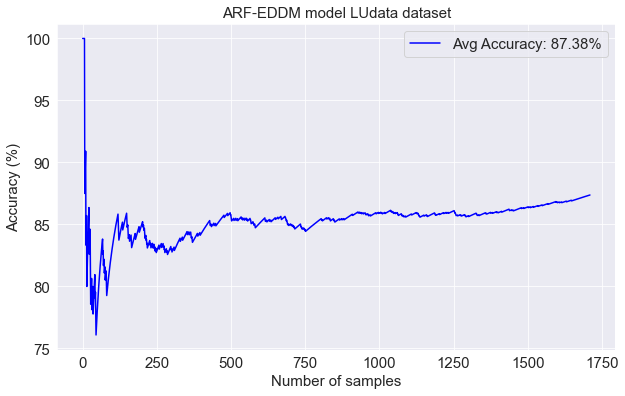

In [7]:
%%time
# Use the Adaptive Random Forest (ARF) model with EDDM drift detector
name1 = "ARF-EDDM model"
model1 = ensemble.AdaptiveRandomForestClassifier(n_models = 3, drift_detector = EDDM()) # Define the model
SEED = np.random.seed(45)
t, m1 = adaptive_learning(model1, X_train, y_train, X_test, y_test) # Learn the model on the dataset
acc_fig(t, m1, name1) # Draw the figure of how the real-time accuracy changes with the number of samples

Accuracy: 93.34%
Precision: 95.23%
Recall: 90.9%
F1-score: 93.01%
Wall time: 2.22 s


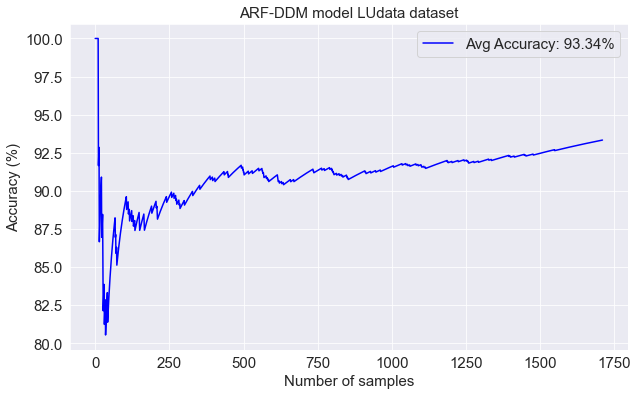

In [8]:
%%time
# Use the Adaptive Random Forest (ARF) model with DDM drift detector
name2 = "ARF-DDM model"
model2 = ensemble.AdaptiveRandomForestClassifier(n_models = 3, drift_detector = DDM()) # Define the model
SEED = np.random.seed(45)
t, m2 = adaptive_learning(model2, X_train, y_train, X_test, y_test) # Learn the model on the dataset
acc_fig(t, m2, name2) # Draw the figure of how the real-time accuracy changes with the number of samples

Accuracy: 92.34%
Precision: 94.56%
Recall: 89.46%
F1-score: 91.94%
Wall time: 2.48 s


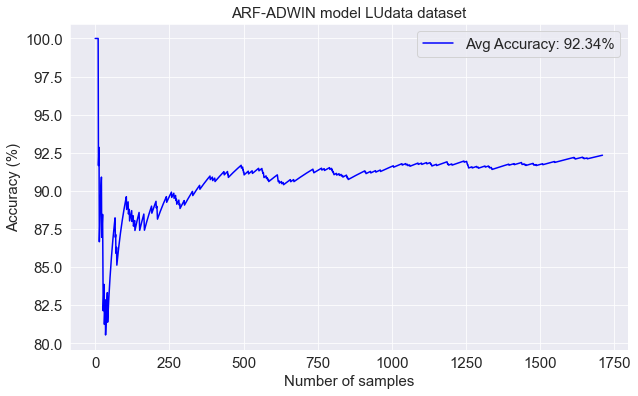

In [9]:
%%time
# Use the Adaptive Random Forest (ARF) model with ADWIN drift detector
name3 = "ARF-ADWIN model"
model3 = ensemble.AdaptiveRandomForestClassifier(n_models = 3, drift_detector = ADWIN()) # Define the model
SEED = np.random.seed(45)
t, m3 = adaptive_learning(model3, X_train, y_train, X_test, y_test) # Learn the model on the dataset
acc_fig(t, m3, name3) # Draw the figure of how the real-time accuracy changes with the number of samples

Accuracy: 93.34%
Precision: 95.23%
Recall: 90.9%
F1-score: 93.01%
Wall time: 2.36 s


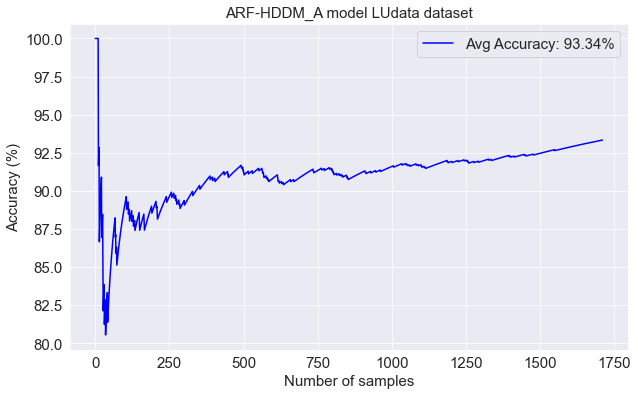

In [10]:
%%time
# Use the Adaptive Random Forest (ARF) model with HDDM_A drift detector
name4 = "ARF-HDDM_A model"
model4 = ensemble.AdaptiveRandomForestClassifier(n_models = 3, drift_detector = HDDM_A()) # Define the model
SEED = np.random.seed(45)
t, m4 = adaptive_learning(model4, X_train, y_train, X_test, y_test) # Learn the model on the dataset
acc_fig(t, m4, name4) # Draw the figure of how the real-time accuracy changes with the number of samples

Accuracy: 93.34%
Precision: 95.23%
Recall: 90.9%
F1-score: 93.01%
Wall time: 2.39 s


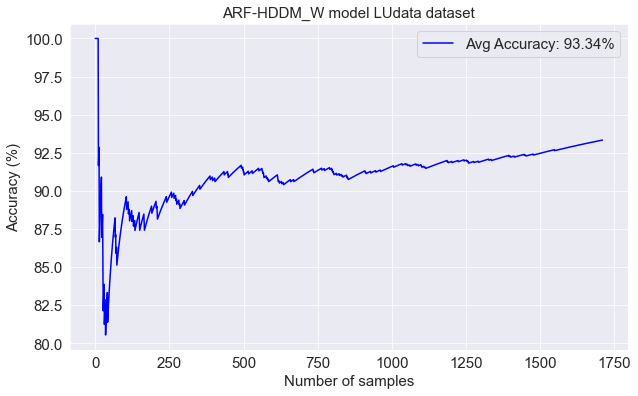

In [11]:
%%time
# Use the Adaptive Random Forest (ARF) model with HDDM_W drift detector
name5 = "ARF-HDDM_W model"
model5 = ensemble.AdaptiveRandomForestClassifier(n_models = 3, drift_detector = HDDM_W()) # Define the model
SEED = np.random.seed(45)
t, m5 = adaptive_learning(model5, X_train, y_train, X_test, y_test) # Learn the model on the dataset
acc_fig(t, m5, name5) # Draw the figure of how the real-time accuracy changes with the number of samples

Accuracy: 99.94%
Precision: 99.88%
Recall: 100.0%
F1-score: 99.94%
Wall time: 2.54 s


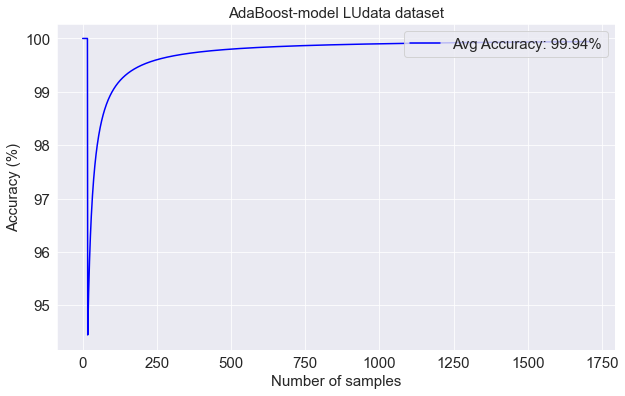

In [12]:
%%time
name6 = "AdaBoost-model"
model6 = ensemble.AdaBoostClassifier(n_models = 3, model=(tree.HoeffdingTreeClassifier())) # Define the model
SEED = np.random.seed(45)
t, m6 = adaptive_learning(model6, X_train, y_train, X_test, y_test) # Learn the model on the dataset
acc_fig(t, m6, name6) # Draw the figure of how the real-time accuracy changes with the number of samples

Accuracy: 94.62%
Precision: 94.71000000000001%
Recall: 94.25%
F1-score: 94.48%
Wall time: 1.44 s


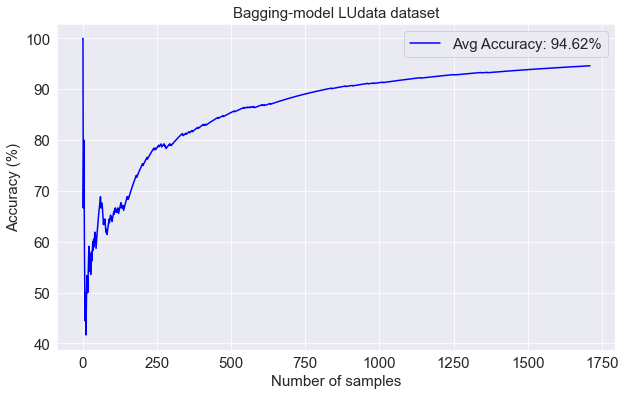

In [13]:
%%time
from river import preprocessing
name7 = "Bagging-model"
model7 = ensemble.BaggingClassifier(n_models = 3, model=(preprocessing.StandardScaler() |linear_model.LogisticRegression())) # Define the model
SEED = np.random.seed(45)
t, m7 = adaptive_learning(model7, X_train, y_train, X_test, y_test) # Learn the model on the dataset
acc_fig(t, m7, name7) # Draw the figure of how the real-time accuracy changes with the number of samples

In [14]:
def EWDAEF(X_train, y_train, X_test, y_test):
    # Record the real-time accuracy of ODDM and 5 base learners
    metric = metrics.Accuracy()
    metric1 = metrics.Accuracy()
    metric2 = metrics.Accuracy()
    metric3 = metrics.Accuracy()
    metric4 = metrics.Accuracy()
    metric5 = metrics.Accuracy()

    i=0
    t = []
    m = []
    m1 = []
    m2 = []
    m3 = []
    m4 = []
    m5 = []
    yt = []
    yp = []
    
    hat1 = ensemble.AdaptiveRandomForestClassifier(n_models = 3, drift_detector = EDDM()) # ARF EDDM
    hat2 = ensemble.AdaptiveRandomForestClassifier(n_models= 3, drift_detector=DDM(),warning_detector=DDM()) # ARF-DDM
    hat3 = ensemble.AdaptiveRandomForestClassifier(n_models = 3, drift_detector = ADWIN())  #ARF ADWIN
    hat4 = ensemble.AdaptiveRandomForestClassifier(n_models = 3, drift_detector = HDDM_A()) # ARF HDDM_A
    hat5 = ensemble.AdaptiveRandomForestClassifier(n_models = 3, drift_detector = HDDM_W()) # ARF HDDM_W
    
    for xi1, yi1 in stream.iter_pandas(X_train, y_train):
        hat1.learn_one(xi1,yi1)
        hat2.learn_one(xi1,yi1)
        hat3.learn_one(xi1,yi1)
        hat4.learn_one(xi1,yi1)
        hat5.learn_one(xi1,yi1)
        
    for xi, yi in stream.iter_pandas(X_test, y_test):
        # The five base learner predict the labels
        y_pred1= hat1.predict_one(xi) 
        y_prob1= hat1.predict_proba_one(xi) 
        hat1.learn_one(xi,yi)

        y_pred2= hat2.predict_one(xi) 
        y_prob2= hat2.predict_proba_one(xi)
        hat2.learn_one(xi,yi)

        y_pred3= hat3.predict_one(xi) 
        y_prob3= hat3.predict_proba_one(xi)
        hat3.learn_one(xi,yi)

        y_pred4= hat4.predict_one(xi) 
        y_prob4= hat4.predict_proba_one(xi)
        hat4.learn_one(xi,yi)
        
        y_pred5= hat5.predict_one(xi) 
        y_prob5= hat5.predict_proba_one(xi)
        hat5.learn_one(xi,yi)
        
        
        metric1 = metric1.update(yi, y_pred1)
        metric2 = metric2.update(yi, y_pred2)
        metric3 = metric3.update(yi, y_pred3)
        metric4 = metric4.update(yi, y_pred4)
        metric5 = metric5.update(yi, y_pred5)
        
        
        e1 = 1-metric1.get()
        e2 = 1-metric2.get()
        e3 = 1-metric3.get()
        e4 = 1-metric4.get()
        e5 = 1-metric5.get()
        
        
        ep = 0.001 # The epsilon used to avoid dividing by 0
        # Calculate the weight of each base learner by the reciprocal of its real-time error rate
        ea = 1/(e1+ep)+1/(e2+ep)+1/(e3+ep)+1/(e4+ep)+1/(e5+ep)
        w1 = 1/(e1+ep)/ea
        w2 = 1/(e2+ep)/ea
        w3 = 1/(e3+ep)/ea
        w4 = 1/(e4+ep)/ea
        w5 = 1/(e5+ep)/ea
        
        
        if  y_pred1 == 1:
            ypro10=1-y_prob1[1]
            ypro11=y_prob1[1]
        else:
            ypro10=y_prob1[0]
            ypro11=1-y_prob1[0]
        if  y_pred2 == 1:
            ypro20=1-y_prob2[1]
            ypro21=y_prob2[1]
        else:
            ypro20=y_prob2[0]
            ypro21=1-y_prob2[0]
        if  y_pred3 == 1:
            ypro30=1-y_prob3[1]
            ypro31=y_prob3[1]
        else:
            ypro30=y_prob3[0]
            ypro31=1-y_prob3[0]
        if  y_pred4 == 1:
            ypro40=1-y_prob4[1]
            ypro41=y_prob4[1]
        else:
            ypro40=y_prob4[0]
            ypro41=1-y_prob4[0]
        if  y_pred5 == 1:
            ypro50=1-y_prob5[1]
            ypro51=y_prob5[1]
        else:
            ypro50=y_prob5[0]
            ypro51=1-y_prob5[0]
            
        
        y_prob_0 = w1*ypro10+w2*ypro20+w3*ypro30+w4*ypro40+w5*ypro50
        y_prob_1 = w1*ypro11+w2*ypro21+w3*ypro31+w4*ypro41+w5*ypro51

        if (y_prob_0>y_prob_1):
            y_pred = 0
            y_prob = y_prob_0
        else:
            y_pred = 1
            y_prob = y_prob_1
            
            
        metric = metric.update(yi, y_pred)

        t.append(i)
        m.append(metric.get()*100)
        yt.append(yi)
        yp.append(y_pred)
        
        i=i+1
    
    print("Accuracy: "+str(round(accuracy_score(yt,yp),4)*100)+"%")
    print("Precision: "+str(round(precision_score(yt,yp),4)*100)+"%")
    print("Recall: "+str(round(recall_score(yt,yp),4)*100)+"%")
    print("F1-score: "+str(round(f1_score(yt,yp),4)*100)+"%")
    return t, m

Accuracy: 100.0%
Precision: 100.0%
Recall: 100.0%
F1-score: 100.0%
Wall time: 12.3 s


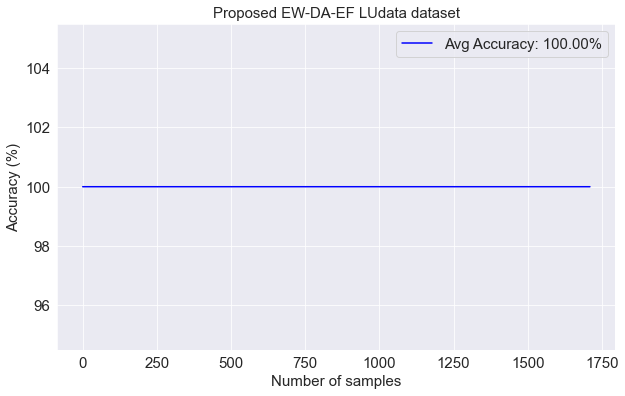

In [15]:
%%time
name = "Proposed EW-DA-EF"
SEED = np.random.seed(45)
t, m = EWDAEF(X_train, y_train, X_test, y_test) # Learn the model on the dataset
acc_fig(t, m, name) # Draw the figure of how the real-time accuracy changes with the number of samples

# PWPAE Model

In [16]:
df = pd.read_csv("C:/Users/sknk0/Desktop/drift datasets/real-world/LUdata.csv")
df = df.sample(n=None, frac=0.1, replace=False, weights=None, random_state=None, axis=0)
df = df.sort_index()

In [17]:
X = df.drop(['target'],axis=1)
y = df['target']
X_train, X_test, y_train, y_test = train_test_split(X,y, train_size = 0.1, test_size = 0.9, shuffle=False,random_state = 0)

In [18]:
# Define a generic adaptive learning function
# The argument "model" means an online adaptive learning algorithm
def adaptive_learning(model, X_train, y_train, X_test, y_test):
    metric40 = metrics.Accuracy() # Use accuracy as the metric
    i = 0 # count the number of evaluated data points
    t4 = [] # record the number of evaluated data points
    m40 = [] # record the real-time accuracy
    yt = [] # record all the true labels of the test set
    yp = [] # record all the predicted labels of the test set

    # Learn the training set
    for xi1, yi1 in stream.iter_pandas(X_train, y_train):
        model.learn_one(xi1,yi1) 

    # Predict the test set
    for xi, yi in stream.iter_pandas(X_test, y_test):
        y_pred= model.predict_one(xi)  # Predict the test sample
        model.learn_one(xi,yi) # Learn the test sample
        metric40 = metric40.update(yi, y_pred) # Update the real-time accuracy
        t4.append(i)
        m40.append(metric40.get()*100)
        yt.append(yi)
        yp.append(y_pred)
        i = i+1
    print("Accuracy: "+str(round(accuracy_score(yt,yp),4)*100)+"%")
    print("Precision: "+str(round(precision_score(yt,yp),4)*100)+"%")
    print("Recall: "+str(round(recall_score(yt,yp),4)*100)+"%")
    print("F1-score: "+str(round(f1_score(yt,yp),4)*100)+"%")
    return t4, m40

In [19]:
# Define a figure function that shows the real-time accuracy changes
def acc_fig(t4, m40, name40):
    plt.rcParams.update({'font.size': 15})
    plt.figure(1,figsize=(10,6)) 
    sns.set_style("darkgrid")
    plt.clf() 
    plt.plot(t4,m40,'-b',label='Avg Accuracy: %.2f%%'%(m40[-1]))

    plt.legend(loc='upper right')
    plt.title(name40+' on LUdata dataset', fontsize=15)
    plt.xlabel('Number of samples')
    plt.ylabel('Accuracy (%)')

    plt.draw()

Accuracy: 72.50999999999999%
Precision: 72.86%
Recall: 64.56%
F1-score: 68.46%
Wall time: 697 ms


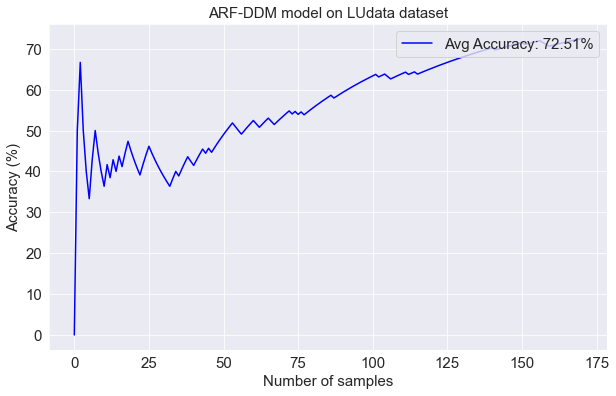

In [20]:
%%time
# Use the Adaptive Random Forest (ARF) model with DDM drift detector
name41 = "ARF-DDM model"
SEED = np.random.seed(45)
model41 = ensemble.AdaptiveRandomForestClassifier(n_models = 3, drift_detector = DDM()) # Define the model
t4, m41 = adaptive_learning(model41, X_train, y_train, X_test, y_test) # Learn the model on the dataset
acc_fig(t4, m41, name41) # Draw the figure of how the real-time accuracy changes with the number of samples

Accuracy: 72.50999999999999%
Precision: 72.86%
Recall: 64.56%
F1-score: 68.46%
Wall time: 431 ms


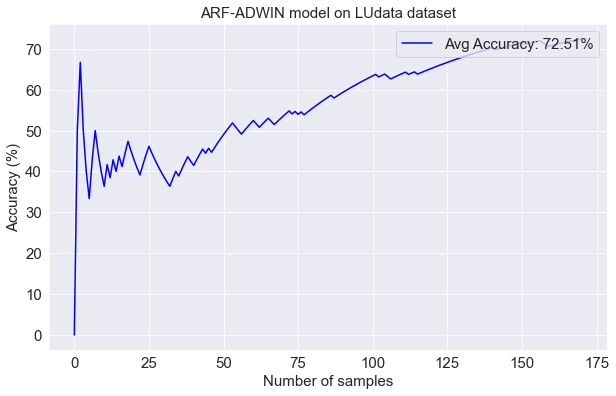

In [21]:
%%time
# Use the Adaptive Random Forest (ARF) model with ADWIN drift detector
name42 = "ARF-ADWIN model"
SEED = np.random.seed(45)
model42 = ensemble.AdaptiveRandomForestClassifier(n_models = 3, drift_detector = ADWIN()) # Define the model
t4, m42 = adaptive_learning(model42, X_train, y_train, X_test, y_test) # Learn the model on the dataset
acc_fig(t4, m42, name42) # Draw the figure of how the real-time accuracy changes with the number of samples

Accuracy: 100.0%
Precision: 100.0%
Recall: 100.0%
F1-score: 100.0%
Wall time: 1.35 s


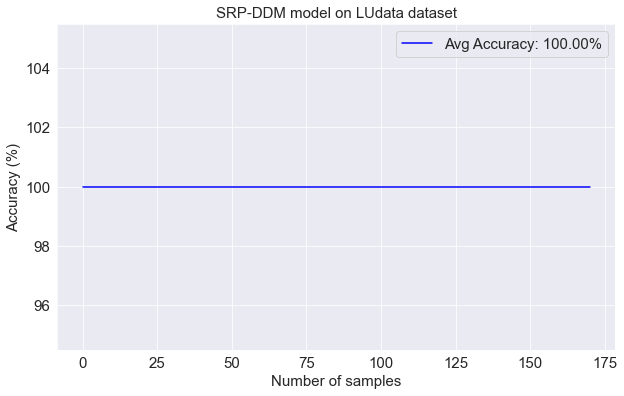

In [27]:
%%time
# Use the Streaming Random Patches (SRP) model with DDM drift detector
name43 = "SRP-DDM model"
SEED = np.random.seed(45)
model43 = ensemble.SRPClassifier(n_models = 3, drift_detector = DDM(), warning_detector=DDM()) # Define the model
t4, m43 = adaptive_learning(model43, X_train, y_train, X_test, y_test) # Learn the model on the dataset
acc_fig(t4, m43, name43) # Draw the figure of how the real-time accuracy changes with the number of samples

Accuracy: 100.0%
Precision: 100.0%
Recall: 100.0%
F1-score: 100.0%
Wall time: 1.28 s


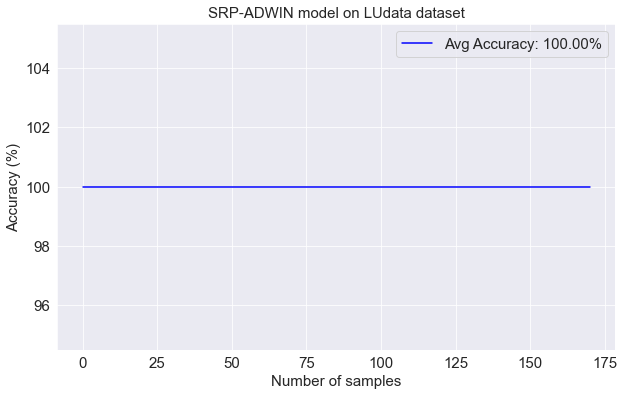

In [28]:
%%time
# Use the Streaming Random Patches (SRP) model with ADWIN drift detector
name44 = "SRP-ADWIN model"
model44 = ensemble.SRPClassifier(n_models = 3, drift_detector = ADWIN()) # Define the model
t4, m44 = adaptive_learning(model44, X_train, y_train, X_test, y_test) # Learn the model on the dataset
acc_fig(t4, m44, name44) # Draw the figure of how the real-time accuracy changes with the number of samples

In [29]:
# Define the Performance Weighted Probability Averaging Ensemble (PWPAE) model
def PWPAE(X_train, y_train, X_test, y_test):
    # Record the real-time accuracy of PWPAE and 4 base learners
    metric40 = metrics.Accuracy()
    metric41 = metrics.Accuracy()
    metric42 = metrics.Accuracy()
    metric43 = metrics.Accuracy()
    metric44 = metrics.Accuracy()

    i=0
    t4 = []
    m40 = []
    m41 = []
    m42 = []
    m43 = []
    m44 = []
    yt = []
    yp = []

    hat51 = ensemble.AdaptiveRandomForestClassifier(n_models=3,drift_detector=DDM(),warning_detector=DDM()) # ARF-DDM
    hat52 = ensemble.AdaptiveRandomForestClassifier(n_models=3) # ARF-ADWIN
    hat53 = ensemble.SRPClassifier(n_models=3,drift_detector=DDM(),warning_detector=DDM()) # SRP-DDM
    hat54 = ensemble.SRPClassifier(n_models=3) # SRP-ADWIN
   
   

    # The four base learners learn the training set
    for xi1, yi1 in stream.iter_pandas(X_train, y_train):
        hat51.learn_one(xi1,yi1)
        hat52.learn_one(xi1,yi1)
        hat53.learn_one(xi1,yi1)
        hat54.learn_one(xi1,yi1)
        
     # Predict the test set
    for xi, yi in stream.iter_pandas(X_test, y_test):
        # The four base learner predict the labels
        y_pred1= hat51.predict_one(xi) 
        y_prob1= hat51.predict_proba_one(xi) 
        hat51.learn_one(xi,yi)

        y_pred2= hat52.predict_one(xi) 
        y_prob2= hat52.predict_proba_one(xi)
        hat52.learn_one(xi,yi)

        y_pred3= hat53.predict_one(xi) 
        y_prob3= hat53.predict_proba_one(xi)
        hat53.learn_one(xi,yi)

        y_pred4= hat54.predict_one(xi) 
        y_prob4= hat54.predict_proba_one(xi)
        hat54.learn_one(xi,yi)
        
        # Record their real-time accuracy
        metric41 = metric41.update(yi, y_pred1)
        metric42 = metric42.update(yi, y_pred2)
        metric43 = metric43.update(yi, y_pred3)
        metric44 = metric44.update(yi, y_pred4)    
        
     # Calculate the real-time error rates of four base learners
        e61 = 1-metric41.get()
        e62 = 1-metric42.get()
        e63 = 1-metric43.get()
        e64 = 1-metric44.get()

        
        ep = 0.001 # The epsilon used to avoid dividing by 0
        # Calculate the weight of each base learner by the reciprocal of its real-time error rate
        ea7 = 1/(e61+ep)+1/(e62+ep)+1/(e63+ep)+1/(e64+ep)
        w81 = 1/(e61+ep)/ea7
        w82 = 1/(e62+ep)/ea7
        w83 = 1/(e63+ep)/ea7
        w84 = 1/(e64+ep)/ea7

        # Make ensemble predictions by the classification probabilities
        if  y_pred1 == 1:
            ypro10=1-y_prob1[1]
            ypro11=y_prob1[1]
        else:
            ypro10=y_prob1[0]
            ypro11=1-y_prob1[0]
        if  y_pred2 == 1:
            ypro20=1-y_prob2[1]
            ypro21=y_prob2[1]
        else:
            ypro20=y_prob2[0]
            ypro21=1-y_prob2[0]
        if  y_pred3 == 1:
            ypro30=1-y_prob3[1]
            ypro31=y_prob3[1]
        else:
            ypro30=y_prob3[0]
            ypro31=1-y_prob3[0]
        if  y_pred4 == 1:
            ypro40=1-y_prob4[1]
            ypro41=y_prob4[1]
        else:
            ypro40=y_prob4[0]
            ypro41=1-y_prob4[0]        

        # Calculate the final probabilities of classes 0 & 1 to make predictions
        y_prob_0 = w81*ypro10+w82*ypro20+w83*ypro30+w84*ypro40
        y_prob_1 = w81*ypro11+w82*ypro21+w83*ypro31+w84*ypro41

        if (y_prob_0>y_prob_1):
            y_pred = 0
            y_prob = y_prob_0
        else:
            y_pred = 1
            y_prob = y_prob_1
        
        # Update the real-time accuracy of the ensemble model
        metric40 = metric40.update(yi, y_pred)

        t4.append(i)
        m40.append(metric40.get()*100)
        yt.append(yi)
        yp.append(y_pred)
        
        i=i+1
    print("Accuracy: "+str(round(accuracy_score(yt,yp),4)*100)+"%")
    print("Precision: "+str(round(precision_score(yt,yp),4)*100)+"%")
    print("Recall: "+str(round(recall_score(yt,yp),4)*100)+"%")
    print("F1-score: "+str(round(f1_score(yt,yp),4)*100)+"%")
    return t4, m40

Accuracy: 100.0%
Precision: 100.0%
Recall: 100.0%
F1-score: 100.0%
Wall time: 2.98 s


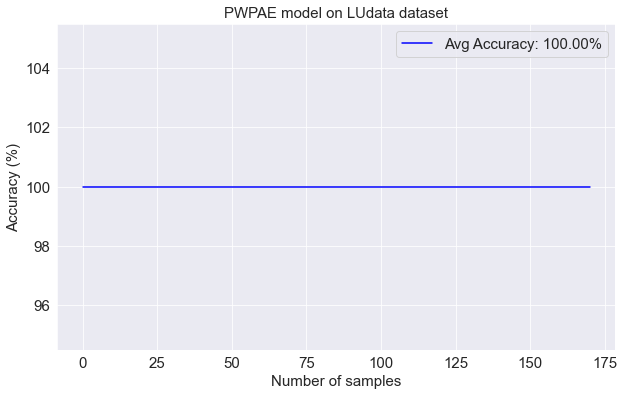

In [30]:
%%time
# Use the Performance Weighted Probability Averaging Ensemble (PWPAE) model 
name40 = "PWPAE model"
t4, m40 = PWPAE(X_train, y_train, X_test, y_test) # Learn the model on the dataset
acc_fig(t4, m40, name40) # Draw the figure of how the real-time accuracy changes with the number of samples

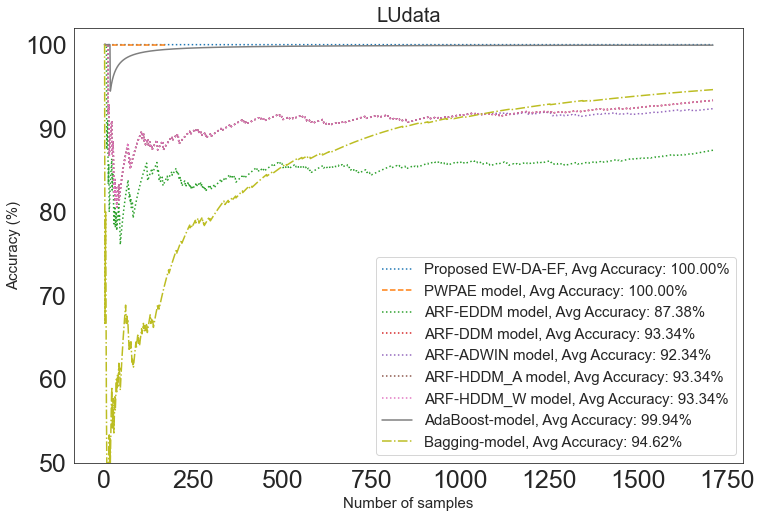

In [31]:
plt.rcParams.update({'font.size': 25})
plt.figure(1,figsize=(12,8)) 
sns.set_style("white")
plt.clf() 

# Plot the accuracy change of each learner
plt.plot(t,m, linestyle ='dotted', label=name+', Avg Accuracy: %.2f%%'%(m[-1]))
plt.plot(t4,m40, linestyle = 'dashed', label=name40+', Avg Accuracy: %.2f%%'%(m40[-1]))
plt.plot(t,m1, linestyle = 'dotted', label=name1+', Avg Accuracy: %.2f%%'%(m1[-1]))
plt.plot(t,m2, linestyle = 'dotted', label=name2+', Avg Accuracy: %.2f%%'%(m2[-1]))
plt.plot(t,m3, linestyle='dotted', label=name3+', Avg Accuracy: %.2f%%'%(m3[-1]))
plt.plot(t,m4, linestyle='dotted', label=name4+', Avg Accuracy: %.2f%%'%(m4[-1]))
plt.plot(t,m5, linestyle='dotted', label=name5+', Avg Accuracy: %.2f%%'%(m5[-1]))
plt.plot(t,m6, linestyle='solid', label=name6+', Avg Accuracy: %.2f%%'%(m6[-1]))
plt.plot(t,m7, linestyle='dashdot', label=name7+', Avg Accuracy: %.2f%%'%(m7[-1]))       
plt.legend(loc='lower right',fontsize=15)
plt.ylim(50, 102)
plt.title('LUdata', fontsize=20)
plt.xlabel('Number of samples', size=15)
plt.ylabel('Accuracy (%)',size=15)

plt.draw()
plt.savefig("FigDrift-92.png")